---
## Loading The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration



In [2]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


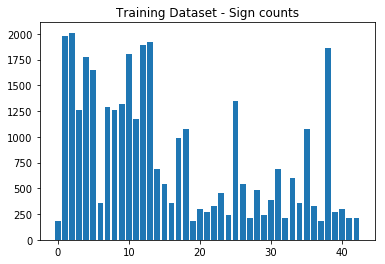

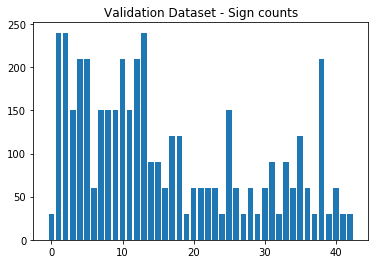

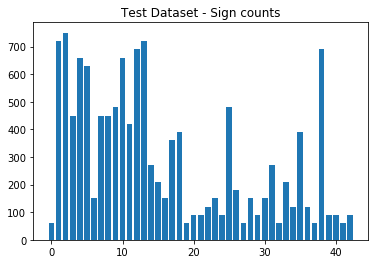

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


# plots the distribution of values inside labels. 'type_of_dataset' is required to name the plot
def show_distribution(labels, type_of_dataset):
    fig = plt.figure()
    ax = plt.subplot()
    unique_labels, count = np.unique(labels, return_counts=True)
    ax.bar(unique_labels, count)
    plt.title( type_of_dataset + " Dataset - Sign counts")
    plt.show()
    fig.savefig("./images/"+ type_of_dataset + "_distribution")

    
show_distribution(y_train, "Training")
show_distribution(y_valid, "Validation")
show_distribution(y_test, "Test")



## Designing and Testing the Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Image data is normalized so that the data has mean zero and equal variance. For image data: `(pixel - 128)/ 128` 

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# gray-scale conversion (averaging RGB)
X_train = np.sum(X_train/3, axis=3, keepdims=True)
X_test = np.sum(X_test/3, axis=3, keepdims=True)
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)

In [5]:
# data augmentation

import math
from sklearn.utils import shuffle


# Functions for Geometric Transformations of Image
def translation_image(img, translation_lbound, translation_hbound):
    del_x, del_y = np.random.randint(translation_lbound, translation_hbound, 2)
    M = np.float32([[1, 0, del_x], [0, 1, del_y]])
    dst = cv2.warpAffine(img, M, (img.shape[0], img.shape[1]))
    dst = dst[:,:,None]
    return dst

# It changes the image to give a top-view of the image
def perspectiveTransformation_image(img):
    w = img.shape[0]
    h = img.shape[1]
    hbound = random.randint(24, h)
    lbound = random.randint(0, 10)
    points_a = np.float32([[0,0],[w,0],[0,h],[w,h]])
    points_b = np.float32([[0, 0], [hbound, lbound], [lbound, h],[w, hbound]])
    M = cv2.getPerspectiveTransform(points_a, points_b)
    dst = cv2.warpPerspective(img, M, (w,h))
    dst = dst[:,:,None]
    return dst
    
# Rotates the image
def rotation_image(img, rotation_lbound, rotation_hbound ):
    w = img.shape[0]
    h = img.shape[1]
    angle = random.randint(rotation_lbound, rotation_hbound)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    dst = cv2.warpAffine(img, M, (w, h))
    dst = dst[:,:,None]
    return dst




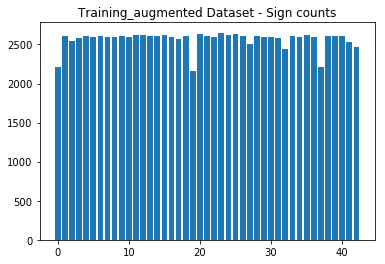

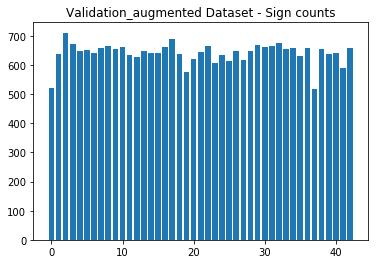

In [6]:
from sklearn.model_selection import train_test_split



# Combining training and validation sets 
X_combined = np.concatenate((X_train, X_valid), axis=0)
y_combined = np.concatenate((y_train, y_valid), axis=0)
n = len(y_combined)

# array to contain new augmented images
X_additional = []
y_additional= []

# Translation lower and higher bound values
l = -4.5
h = 5
# Rotation lower and higher bound values
rlb = -30
rhb = 30                       

unique_signs, count = np.unique(y_combined, return_counts=True)

# Setting the limit for 'intended' count of each sign
max_count = max(count) + 1000

for i in range(n):
    if(count[y_combined[i]] < max_count):
        
        # augment images from this image and add update X_additional, y_additional
        for j in range( 4 ):
            img = X_combined[i]
            # append a translated image
            X_additional.append(translation_image(img, l, h))
            y_additional.append(y_combined[i])
            
            # append a rotated image
            X_additional.append(rotation_image(img, rlb, rhb))
            y_additional.append(y_combined[i])
            
            # append a perspective-transformed image
            X_additional.append(perspectiveTransformation_image(img))
            y_additional.append(y_combined[i])
            
            # update the count of this label in counts_train.
            count[y_combined[i]] += 3
                       
                       
X_ = np.concatenate((X_combined, X_additional), axis=0)
y_ = np.concatenate((y_combined, y_additional), axis=0)


X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=0)

show_distribution(y_train, "Training_augmented")
show_distribution(y_valid, "Validation_augmented")


In [7]:
# Normalization

X_train_normalized = (X_train-128)/128
X_valid_normalized = (X_valid-128)/128
X_test_normalized = (X_test-128)/128

X_train = X_train_normalized
X_valid = X_valid_normalized
X_test = X_test_normalized


### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
     # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 35
BATCH_SIZE = 156


# Set the placeholders (for data/labels)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.0009

# forward pass
logits = LeNet(x)

# Compares result of forward-pass (logits) and labels to give accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Calculate Loss/Cost
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

#For running Backprop
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


saver = tf.train.Saver()

# Returns the accuracy on validation-set
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    # Each Epoch: trains on random-batch of training data, reports accuracy on validation_set
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_german_traffic.ckpt')
    print("Model saved")
    sess.close()

Training...

EPOCH 1 ...
Validation Accuracy = 0.675

EPOCH 2 ...
Validation Accuracy = 0.801

EPOCH 3 ...
Validation Accuracy = 0.855

EPOCH 4 ...
Validation Accuracy = 0.880

EPOCH 5 ...
Validation Accuracy = 0.905

EPOCH 6 ...
Validation Accuracy = 0.918

EPOCH 7 ...
Validation Accuracy = 0.920

EPOCH 8 ...
Validation Accuracy = 0.930

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.945

EPOCH 11 ...
Validation Accuracy = 0.950

EPOCH 12 ...
Validation Accuracy = 0.952

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.956

EPOCH 15 ...
Validation Accuracy = 0.955

EPOCH 16 ...
Validation Accuracy = 0.956

EPOCH 17 ...
Validation Accuracy = 0.962

EPOCH 18 ...
Validation Accuracy = 0.955

EPOCH 19 ...
Validation Accuracy = 0.965

EPOCH 20 ...
Validation Accuracy = 0.963

EPOCH 21 ...
Validation Accuracy = 0.963

EPOCH 22 ...
Validation Accuracy = 0.969

EPOCH 23 ...
Validation Accuracy = 0.962

EPOCH 24 ...
Validation Accura

In [11]:
# Accuracy of the model on the test-dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('lenet_german_traffic.ckpt.meta')
    saver2.restore(sess, "./lenet_german_traffic.ckpt")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))
    
sess.close()

Test Set Accuracy = 0.906


---

##### Not the Best Test accuracy. I will change and retrain the model to get better test set accuracy in future.

---

---

## Testing the  Model on New Images

### Loading and Output the Images

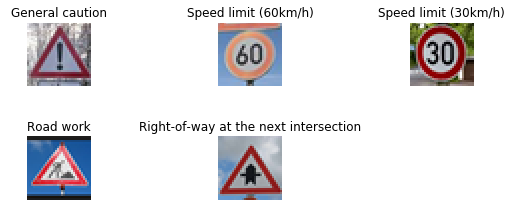

(5, 32, 32, 1)


In [19]:

import numpy as np
import glob
import csv
import matplotlib.pyplot as plt
import cv2

original_img_list = []
t_images = []
t_labels = [18, 3, 1, 25, 11]
t_labels = np.asarray(t_labels)

signNames = {}
signNamesFile = open("./signnames.csv")
signNameReader = csv.reader( signNamesFile , delimiter=',')
next(signNameReader)
for row in signNameReader:
    signNames[int(row[0])] = row[1]

prefix = "./new_images/"


img_list = glob.glob(prefix + '*.png')
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=2)
plt.clf()

for i, img in enumerate(img_list):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32,32))
    original_img_list.append(image)
    ax = fig.add_subplot(4,3,i+1) 
    ax.set_title(signNames[t_labels[i]])
    ax.imshow(image)
    ax.axis('off')
    t_images.append(image)

plt.show()
    
# conversion to ndarray
t_images = np.asarray(t_images)

# Gray-scaling
t_images = np.sum(t_images/3, axis=3, keepdims=True)

# normalization
t_images = (t_images - 128)/128 

print(t_images.shape)

### Predicting the Sign Type for sample images

In [1]:


import tensorflow as tf


fig2 = plt.figure(figsize=(8,8))
fig2.subplots_adjust(wspace=2, hspace = 0.001)
plt.clf()

with tf.Session() as sess:
    saver3 = tf.train.import_meta_graph('lenet_german_traffic.ckpt.meta')
    saver3.restore(sess, "./lenet_german_traffic.ckpt")
    predicted_logits = sess.run(logits, feed_dict={x: t_images})
    predicted_labels = np.argmax(predicted_logits, axis=1)
    for i,j in enumerate(predicted_labels):
        ax = fig2.add_subplot(2,3,i+1) 
        ax.set_title(signNames[j])
        ax.imshow(original_img_list[i])
        ax.axis('off')
    plt.show()
    
sess.close()

NameError: name 'plt' is not defined

##### One image out of five is misclassified here.

### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('lenet_german_traffic.ckpt.meta')
    saver3.restore(sess, "./lenet_german_traffic.ckpt")
    test_accuracy = evaluate(t_images, t_labels)
    print("New images Accuracy = {:.3f}".format(test_accuracy))

sess.close()

New images Accuracy = 0.800


### Top 5 Softmax Probabilities For Each Image

In [20]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


with tf.Session() as sess:
    softmax = tf.nn.softmax(predicted_logits)
    top5 = sess.run(tf.nn.top_k(softmax, k=5))
    for i, signNum in enumerate(t_labels):
        print("Actual Sign: " + signNames[signNum])
        for j in range(5):
            print("{:s}: {:.4f}%".format(signNames[top5[1][i][j]], top5[0][i][j]*100))
        print("\n")

sess.close()

Actual Sign: General caution
General caution: 100.0000%
Pedestrians: 0.0000%
Traffic signals: 0.0000%
Speed limit (20km/h): 0.0000%
Speed limit (30km/h): 0.0000%


Actual Sign: Speed limit (60km/h)
Speed limit (60km/h): 99.9765%
Road work: 0.0235%
Speed limit (80km/h): 0.0000%
Speed limit (50km/h): 0.0000%
Roundabout mandatory: 0.0000%


Actual Sign: Speed limit (30km/h)
Speed limit (30km/h): 99.8264%
Speed limit (20km/h): 0.1736%
Speed limit (50km/h): 0.0000%
Roundabout mandatory: 0.0000%
Speed limit (80km/h): 0.0000%


Actual Sign: Road work
Children crossing: 99.9993%
Road work: 0.0007%
Road narrows on the right: 0.0000%
Beware of ice/snow: 0.0000%
Dangerous curve to the right: 0.0000%


Actual Sign: Right-of-way at the next intersection
Right-of-way at the next intersection: 99.9999%
Beware of ice/snow: 0.0001%
Children crossing: 0.0000%
Dangerous curve to the right: 0.0000%
Pedestrians: 0.0000%


